<a href="https://colab.research.google.com/github/gedeck/mistat-code-solutions/blob/main/ModernStatistics/notebooks/Chap008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
!pip install mistat scikit-fda pgmpy scipy==1.11.4 --quiet

scipy needs to be fixed to 1.11.4 for current release of scikit-fda - issue fixed in repository, but not yet released

# Modern analytic methods: Part II

In [2]:
import networkx as nx

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mistat

## Functional Data Analysis

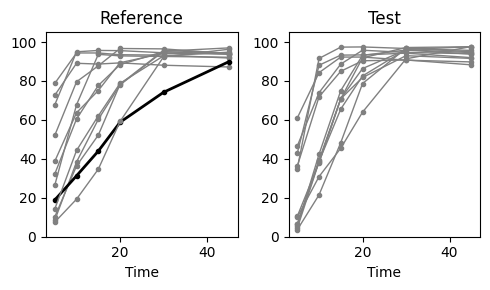

In [3]:
dissolution = mistat.load_data('DISSOLUTION.csv')

fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for label, group in dissolution.groupby('Label'):
  ax = axes[0] if label.endswith('R') else axes[1]
  color = 'black' if label == 'T5R' else 'grey'
  lw = 2 if label == 'T5R' else 1
  group.plot(x='Time', y='Data', color=color, ax=ax,
             marker='o', markersize=3, lw=lw)
for ax in axes:
  ax.get_legend().remove()
  ax.set_ylim(0, 105)
axes[0].set_title('Reference')
axes[1].set_title('Test')
plt.tight_layout()
plt.show()

In [4]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation


# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(2))

In [5]:
from skfda.exploratory import stats

mean_ref = stats.mean(fd[labels=='Reference'])
mean_test = stats.mean(fd[labels=='Test'])
means = mean_ref.concatenate(mean_test)

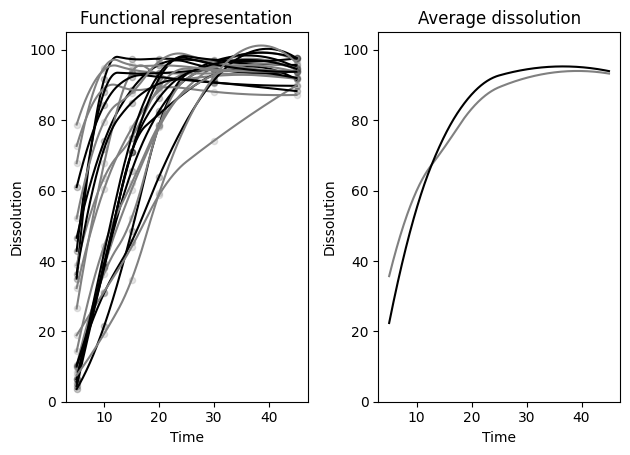

In [6]:
group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=2)

fd.plot(axes=[axes[0]], group=labels, group_colors=group_colors)
for label, group in dissolution.groupby('Label'):
  color = 'grey' if label.endswith('R') else 'black'
  group.plot.scatter(x='Time', y='Data', c=color, ax=axes[0], alpha=0.2)

means.plot(axes=[axes[1]], group=['Reference', 'Test'],
           group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Functional representation')
axes[1].set_title('Average dissolution')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [7]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()
fd_registered = shift_registration.fit_transform(fd)

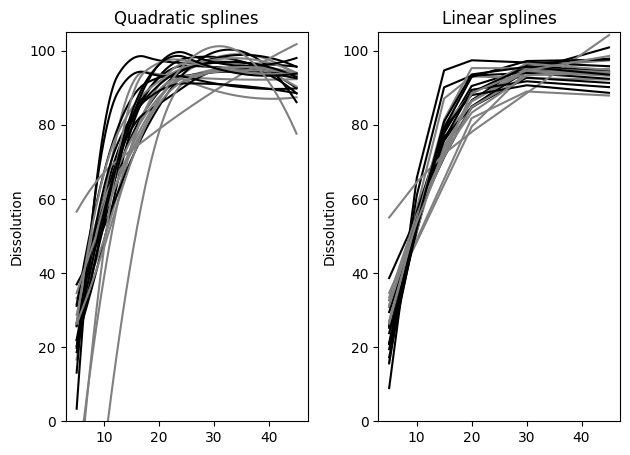

In [8]:
fig, axes = plt.subplots(ncols=2)
fd_registered.plot(axes=[axes[0]], group=labels, group_colors=group_colors)

# switch to linear spline interpolation
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'],
       interpolation=SplineInterpolation(1, monotone=True))
fd_registered = shift_registration.fit_transform(fd)
fd_registered.plot(axes=[axes[1]], group=labels, group_colors=group_colors)

fig.suptitle('')
axes[0].set_title('Quadratic splines')
axes[1].set_title('Linear splines')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [9]:
from skfda.exploratory.outliers import BoxplotOutlierDetector

out_detector = BoxplotOutlierDetector()
outliers = out_detector.fit_predict(fd)
print('Outlier:')
for name, outlier in zip(names, outliers):
  if outlier == 1:
    continue
  print('  ', name)

Outlier:
   T5R


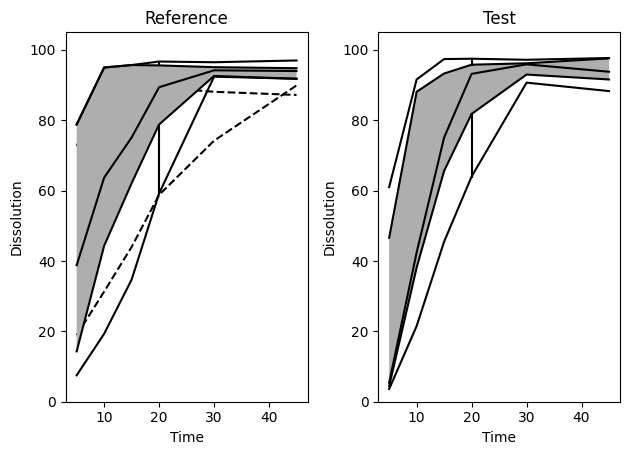

In [10]:
from skfda.exploratory.visualization import Boxplot
from matplotlib.colors import LinearSegmentedColormap

def addBoxplot(fd, ax):
  cm = LinearSegmentedColormap.from_list('fda', ['grey', 'lightgrey'])
  boxplot = Boxplot(fd, axes=[ax])
  boxplot.barcol = 'black'
  boxplot.outliercol = 'black'
  boxplot.colormap = cm
  boxplot.plot()

fig, axes = plt.subplots(ncols=2)
addBoxplot(fd[labels=='Reference'], axes[0])
addBoxplot(fd[labels=='Test'], axes[1])
fig.suptitle('')
axes[0].set_title('Reference')
axes[1].set_title('Test')
for ax in axes:
  ax.set_ylim(0, 105)
  ax.set_ylabel('Dissolution')
plt.tight_layout()
plt.show()

In [11]:
import scipy
scipy.__version__

'1.11.4'

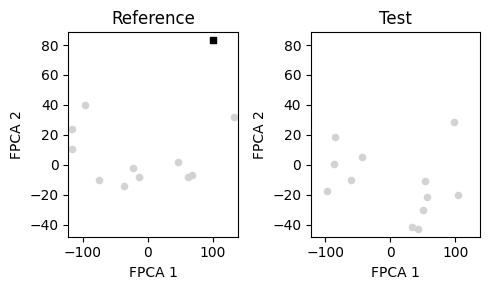

In [12]:
from skfda.preprocessing.dim_reduction import FPCA
fpca = FPCA(n_components=2)
fpca.fit(fd)

df = pd.DataFrame(fpca.transform(fd), columns=['FPCA 1', 'FPCA 2'])
df['labels'] = labels
df['names'] = names

lim1 = (min(df['FPCA 1'])-5, max(df['FPCA 1'])+5)
lim2 = (min(df['FPCA 2'])-5, max(df['FPCA 2'])+5)
fig, axes = plt.subplots(ncols=2, figsize=(5, 3))
for ax, label in zip(axes, ['Reference', 'Test']):
  subset = df[df.labels == label]
  subset.plot.scatter(x='FPCA 1', y='FPCA 2', ax=ax, color='lightgrey')
  ax.set_title(label)
  ax.set_xlim(*lim1)
  ax.set_ylim(*lim2)
outlier = df[df.names == 'T5R']
outlier.plot.scatter(x='FPCA 1', y='FPCA 2', color='black',
  marker='s', ax=axes[0])

plt.tight_layout()
plt.show()

## Text Analytics

In [13]:
incidents = mistat.load_data('AIRCRAFTINCIDENTS.csv')
print(incidents.shape)

(1906, 27)


In [14]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(incidents['Final Narrative'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (1906, 8430)
total number of terms 163883


In [15]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]:10s}  {termCounts[n]:5d}')

pilot        5227
airplane     5037
engine       2359
flight       2194
landing      2161
runway       2112
left         1754
feet         1609
fuel         1589
right        1555


In [16]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [17]:
narrative = incidents['Final Narrative'][0]
narrative = '\n'.join(narrative.split('\n')[2:])

In [18]:
terms = vectorizer.get_feature_names_out()
docterms = counts[0,:].nonzero()[1]
df = pd.DataFrame({
  'Terms': [terms[i] for i in docterms],
  'Counts': [counts[0, i] for i in docterms],
  'TF-IDF': [tfidf[0, i] for i in docterms],
  'weight': [tfidf[0, i] / counts[0, i] for i in docterms]
})
df = df.sort_values('TF-IDF', ascending=False)

In [19]:
df.head(10)

,Terms,Counts,TF-IDF,weight
9,lincoln,2,14.908300,7.454150
10,logan,1,8.552762,8.552762
1,said,3,8.233859,2.744620
13,illinois,1,7.166468,7.166468
30,upside,1,6.355538,6.355538
23,came,2,5.671469,2.835734
26,plowed,1,5.557030,5.557030
5,runway,3,5.486789,1.828930
11,county,1,5.461720,5.461720
6,feet,3,5.408493,1.802831


In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(1906, 10)


In [21]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [22]:
df.round(4).transpose()

,0,1,2,3,4,5,6,7,8,9
Topic 1,airplane,pilot,runway,landing,fuel,engine,left,right,reported,flight
Loading 1,0.3515,0.2824,0.2347,0.1907,0.1901,0.1862,0.1676,0.1525,0.1474,0.1404
Topic 2,fuel,engine,tank,tanks,gallons,power,selector,forced,carburetor,loss
Loading 2,0.671,0.2862,0.2383,0.1245,0.1242,0.1161,0.0913,0.0897,0.0815,0.0643
Topic 3,helicopter,rotor,flight,tail,engine,feet,blades,collective,ground,instructor
Loading 3,0.611,0.2412,0.1426,0.1007,0.1001,0.0986,0.0962,0.0962,0.0904,0.083
Topic 4,helicopter,gear,landing,right,main,left,rotor,fuel,student,instructor
Loading 4,0.3549,0.3283,0.2696,0.2061,0.2032,0.1658,0.1522,0.1239,0.1164,0.1137
Topic 5,fuel,knots,helicopter,wind,tank,aircraft,runway,winds,degrees,right
Loading 5,0.3405,0.2186,0.2034,0.1726,0.1668,0.1408,0.1255,0.12,0.1151,0.1068


## Bayesian Networks

In [23]:
from pgmpy.estimators import HillClimbSearch

abc = mistat.load_data('ABC2.csv')
abc = abc.drop(columns=['ID'])

est = HillClimbSearch(data=abc)
model = est.estimate(max_indegree=1, max_iter=int(1e4), show_progress=False,
                     scoring_method='k2score')

In [24]:
import graphviz
from tempfile import TemporaryDirectory
from IPython.display import Image

def layoutGraph(dot_data, pdfFile=None):
    graph = graphviz.Source(dot_data)
    with TemporaryDirectory() as tempdir:
        if pdfFile is not None:
            graph.render('dot', directory=tempdir, format='pdf', outfile=pdfFile)
        return Image(graph.render('dot', directory=tempdir, format='png'))

def createGraph(G, pdfFile=None):
    sortedNodes = list(nx.topological_sort(G))
    commonSettings = """
    edge [ fontsize=11, color=gray55 ];
    # size="10,10"
    graph [ranksep="0.2", dpi=300];
    """
    def makeNode(label):
        return f'{label} [ label="{label}", fontsize=11, color=white ];'
    def makeEdge(edge):
        fromNode, toNode = edge
        return f'{fromNode} -> {toNode};'

    allNodes = '\n'.join(makeNode(node) for node in sortedNodes)
    allEdges = '\n'.join(makeEdge(edge) for edge in G.edges)

    s = f"""
    digraph ethane {{
    { commonSettings }
    { allNodes }
    { allEdges }
     }}
     """
    return layoutGraph(s, pdfFile)

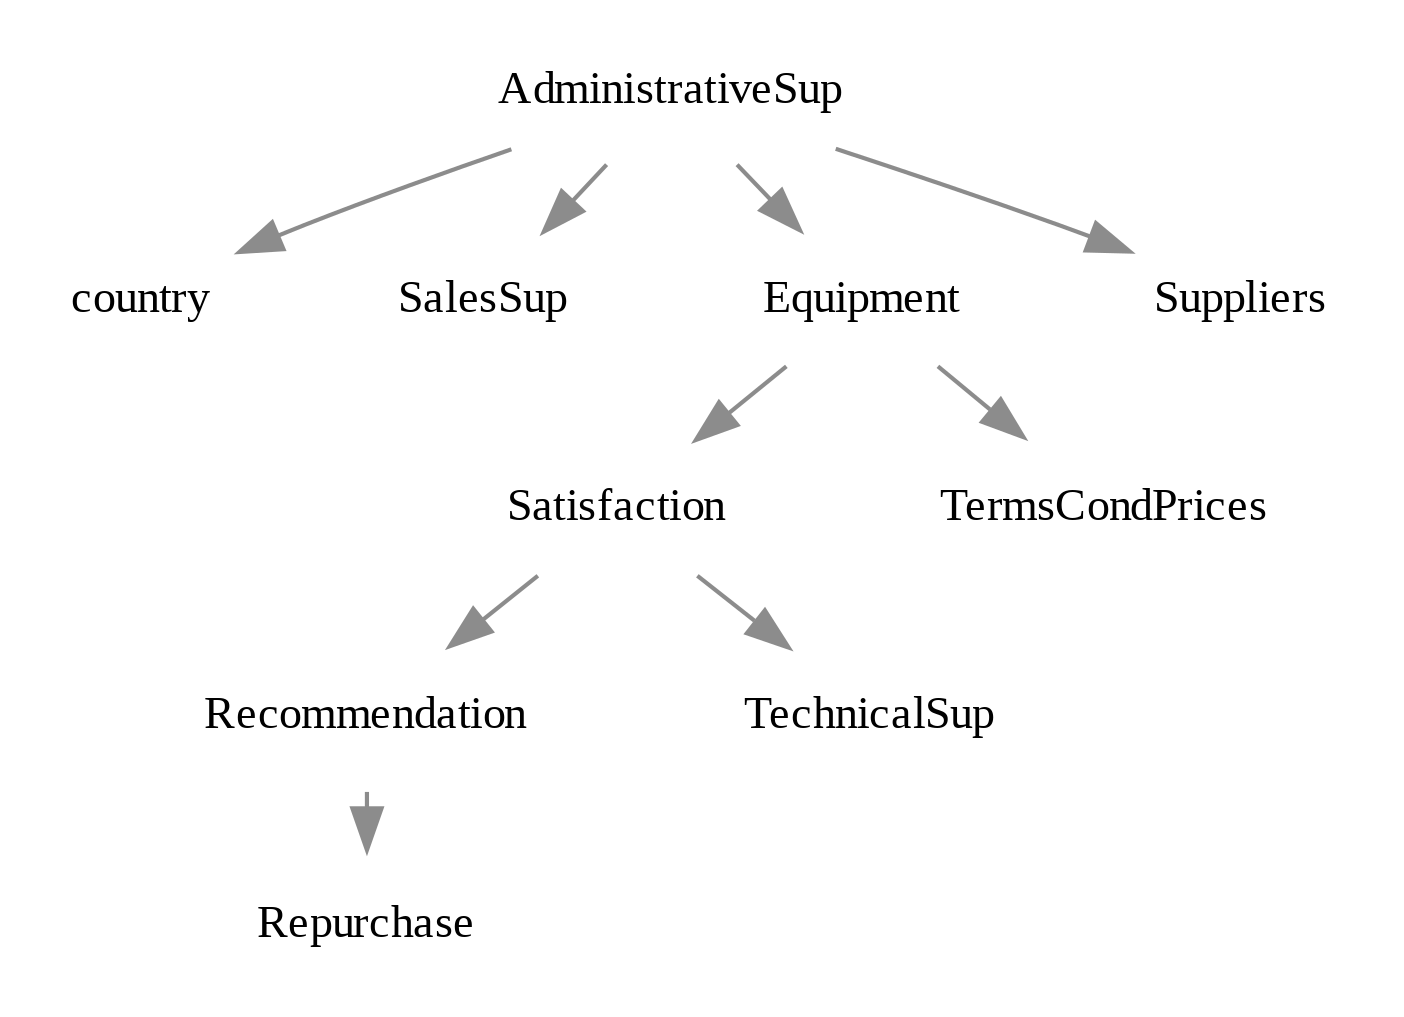

In [25]:
createGraph(model)

In [26]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# convert to BayesianNetwork and fit data
model = BayesianNetwork(model.edges())
model.fit(data=abc, estimator=MaximumLikelihoodEstimator)

In [27]:
for cpd in model.get_cpds():
  df = pd.DataFrame(cpd.values)
  v0 = cpd.variables[0]
  df.index = pd.MultiIndex.from_tuples([(v0, state) for state in cpd.state_names[v0]])
  if len(cpd.variables) > 1:
    v1 = cpd.variables[1]
    df.columns = pd.MultiIndex.from_tuples([(v1, state) for state in cpd.state_names[v1]])
  print(df.round(3))
  break

                 Equipment                            
                       1.0    2.0    3.0    4.0    5.0
Satisfaction 1.0     0.667  0.167  0.042  0.007  0.000
             2.0     0.167  0.444  0.083  0.056  0.118
             3.0     0.000  0.278  0.556  0.148  0.059
             4.0     0.167  0.111  0.278  0.606  0.412
             5.0     0.000  0.000  0.042  0.183  0.412


In [28]:
from pgmpy.inference import VariableElimination, BeliefPropagation
infer = BeliefPropagation(model)
results = {i: infer.query(variables=['Repurchase'],
                          evidence={'TechnicalSup': i}).values
           for i in range(1, 6)}

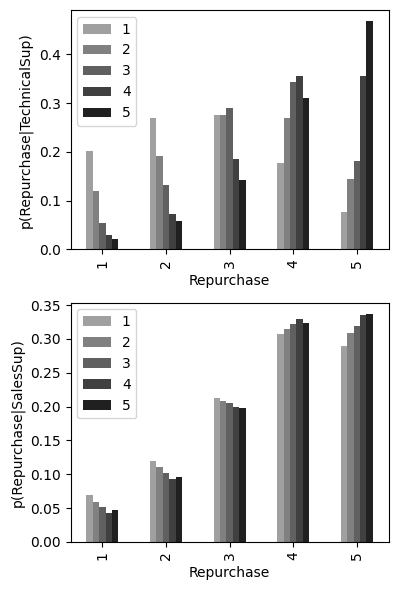

In [29]:
fig, axes = plt.subplots(nrows=2,figsize=(4, 6))

cmap = plt.get_cmap("gray")
greyColors = [cmap(i/8) for i in reversed(range(1, 6))]

ax = axes[0]
df = pd.DataFrame(results, index=range(1,6))
df.plot(kind='bar', stacked=False, ax=ax, color=greyColors)
ax.set_xlabel('Repurchase')
ax.set_ylabel('p(Repurchase|TechnicalSup)')

results = {i: infer.query(variables=['Repurchase'],
                          evidence={'SalesSup': i}).values
           for i in range(1, 6)}
ax = axes[1]
df = pd.DataFrame(results, index=range(1,6))
df.plot(kind='bar', stacked=False, ax=ax, color=greyColors)
ax.set_xlabel('Repurchase')
ax.set_ylabel('p(Repurchase|SalesSup)')

plt.tight_layout()
plt.show()

In [30]:
import itertools
cmap = plt.get_cmap("gray")
greyColors = [cmap(i/8) for i in reversed(range(1, 6))]

def inferAll(evidence=None):
    results = {}
    countries = list(abc.country.unique())
    for column in abc.columns:
        if evidence is not None and column in evidence:
            if column == 'country':
                country = evidence['country']
                result = [0] * len(countries)
                result[countries.index(country)] = 1
                idx = countries
            else:
                idx = range(1, 6)
                result = [0] * 5
                result[evidence[column] - 1] = 1
        else:
            result = infer.query(variables=[column], evidence=evidence, show_progress=False)
            idx = range(1, 6)
            if column == 'country':
                idx = countries
            result = result.values
        results[column] = pd.DataFrame({column: result}, index=idx)
    return results

def plotInferAll(results):
    fig, axes = plt.subplots(ncols=4, nrows=3)
    for column, ax in itertools.zip_longest(results, itertools.chain(*axes)):
        if column is None:
            ax.axis('off')
            continue
        results[column].plot(kind='bar', color='grey', ax=ax, legend=False)
        ax.set_title(column)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

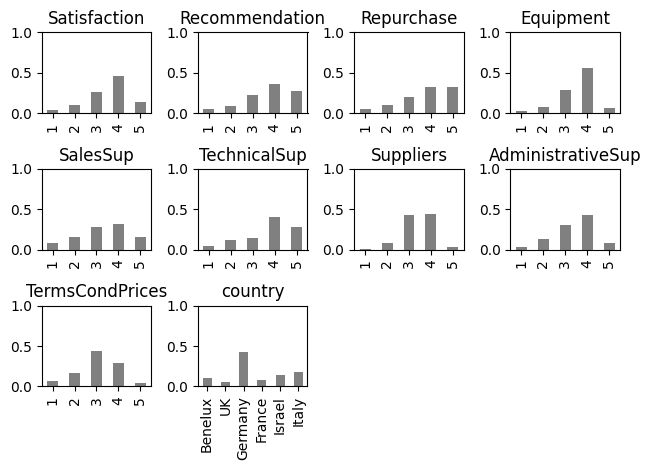

In [31]:
results = inferAll()
plotInferAll(results)

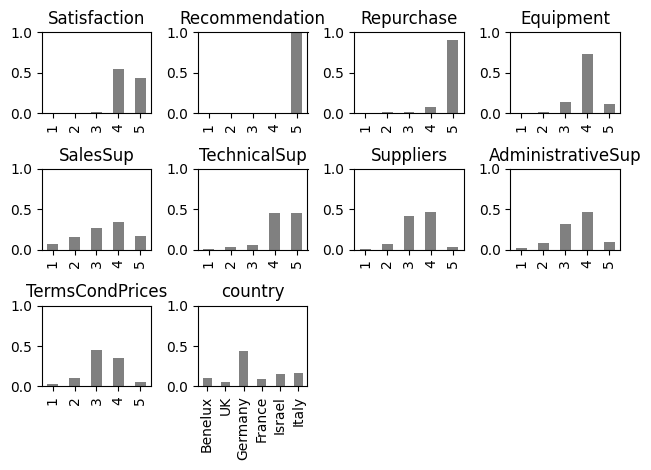

In [32]:
results = inferAll(evidence={'Recommendation': 5})
plotInferAll(results)

In [33]:
results = {i: infer.query(variables=['TechnicalSup'],
                          evidence={'country': i}).values
           for i in sorted(abc.country.unique())}
df = pd.DataFrame(results, range(1,6))

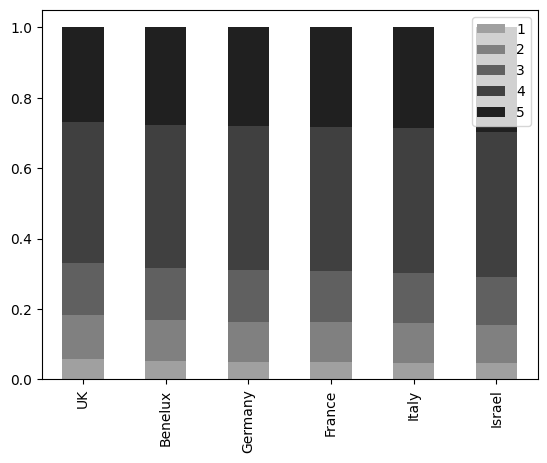

In [34]:
# sort columns by increasing estimated technical support score
columns = sorted(df.columns, key=lambda c: np.sum(np.arange(1, 6) * df[c]))
df = df[columns]
df.transpose().plot(kind='bar', stacked=True, color=greyColors)
plt.show()

## Causality Models

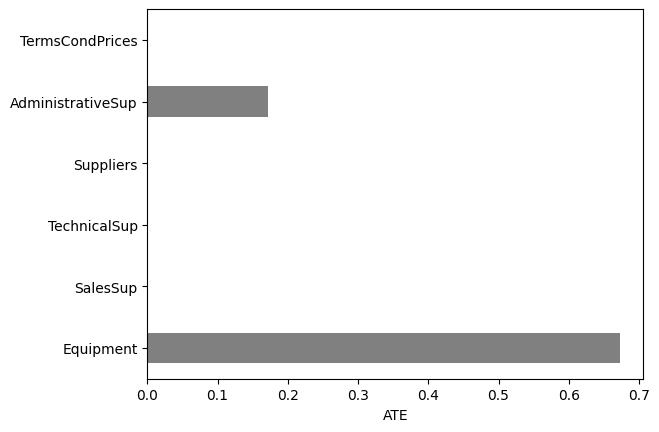

In [35]:
from pgmpy.inference.CausalInference import CausalInference
ci = CausalInference(model)
ignore = ('Satisfaction', 'country', 'Recommendation', 'Repurchase')
interventions = [c for c in abc.columns if c not in ignore]
ate = {c: ci.estimate_ate(c, 'Satisfaction', abc, missing='drop')
       for c in interventions}
ax = pd.Series(ate).plot.barh(color='grey')
ax.set_xlabel('ATE')
plt.show()

In [36]:
distTower = mistat.load_data('DISTILLATION-TOWER.csv')
distTower = distTower.set_index('Date')
subset = ['VapourPressure', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5',
          'Temp6', 'Temp7', 'Temp8', 'Temp9', 'Temp10','Temp11','Temp12']
distTower = distTower[subset]
results = []
for c in subset[1:]:
    # use pct_change to make time series stationary
    data = distTower[["VapourPressure", c]].pct_change().dropna()
    gc_res = grangercausalitytests(data, 10)
    results.append({f'lag {i}': gc[0]['ssr_ftest'][1]
                    for i, gc in gc_res.items()})
df = pd.DataFrame(results, index=subset[1:])
df['id'] = df.index


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3723 , p=0.0000  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=17.5825 , p=0.0000  , df=1
likelihood ratio test: chi2=16.9940 , p=0.0000  , df=1
parameter F test:         F=17.3723 , p=0.0000  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9309 , p=0.0000  , df_denom=245, df_num=2
ssr based chi2 test:   chi2=22.3081 , p=0.0000  , df=2
likelihood ratio test: chi2=21.3683 , p=0.0000  , df=2
parameter F test:         F=10.9309 , p=0.0000  , df_denom=245, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3191  , p=0.0001  , df_denom=242, df_num=3
ssr based chi2 test:   chi2=22.5924 , p=0.0000  , df=3
likelihood ratio test: chi2=21.6255 , p=0.0001  , df=3
parameter F test:         F=7.3191  , p=0.0001  , df_denom=242, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9097  , p=0.0000  

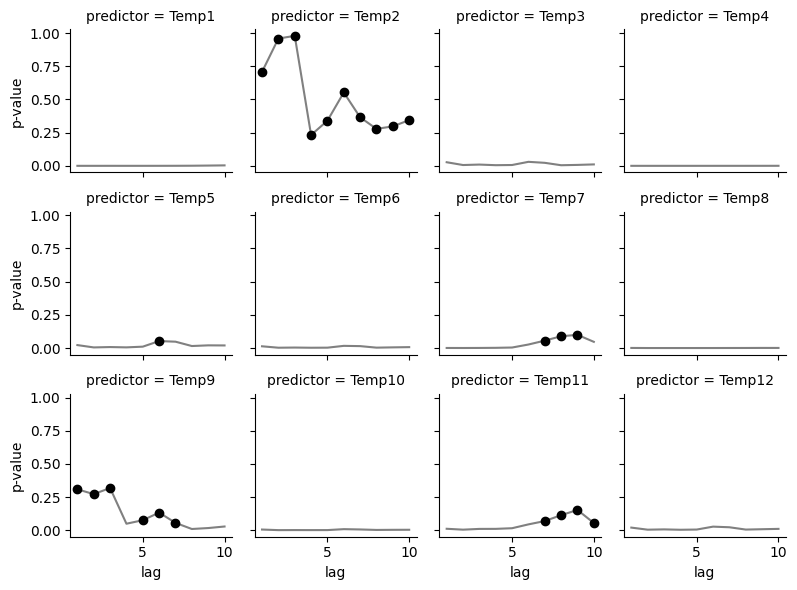

In [37]:
df = pd.wide_to_long(df, 'lag ', 'id', 'VapourPressure')
df = df.reset_index()
df.columns = ('predictor', 'lag', 'p-value')

def plotLag(x, y, **kwargs):
    ax = plt.gca()
    ax.plot(x, y, **kwargs)
    sig = y > 0.05
    ax.scatter(x[sig], y[sig], color='black',zorder=10)

g = sns.FacetGrid(df, col="predictor", col_wrap=4, height=2)
g.map(plotLag, 'lag', 'p-value', color='grey')
plt.show()

## Chapter Highlights

## Exercises